# Compare predictions
Compute the jaccard index of the top k predictions 
- across all networks for a given alg
- across all algs for a given network


In [1]:
# the rest of the imports require the location to be the base of the repo 
#   i.e., SARS-CoV-2-network-analysis)
# run this first if needed to get to the right directory
import os
os.chdir('../../')
# os.chdir('/data/jeff-law/projects/2020-03-covid-19/SARS-CoV-2-network-analysis')
os.getcwd()

'/data/jeff-law/projects/2020-03-covid-19/SARS-CoV-2-network-analysis'

In [2]:
from collections import defaultdict
import argparse
import os, sys
from tqdm import tqdm
import itertools
#import utils.file_utils as utils
# also compute the significance of sinksource vs local
#from scipy.stats import kruskal, mannwhitneyu
# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
print("python version: %s" % (sys.version.split('\n')[0]))
print("matplotlib version: %s" % matplotlib.__version__)
print("seaborn version: %s" % sns.__version__)
print("pandas version: %s" % pd.__version__)
print("numpy version: %s" % (np.__version__))
# make this the default for now
sns.set_style('darkgrid')
# my local imports
# fss_dir = os.path.dirname(os.path.dirname(os.path.dirname(__file__)))
# sys.path.insert(0,fss_dir)
from src.FastSinkSource.src import main as run_eval_algs
from src.FastSinkSource.src.plot import plot_utils
from src.FastSinkSource.src.algorithms import runner
from src.FastSinkSource.src.algorithms import alg_utils
from src.FastSinkSource.src.utils import config_utils
from src.FastSinkSource.src.evaluate import cross_validation as cv

python version: 3.7.7 (default, Mar 13 2020, 13:32:22) 
matplotlib version: 3.2.1
seaborn version: 0.10.0
pandas version: 1.0.3
numpy version: 1.18.2


In [3]:
def load_all_pred(input_settings, output_dir, alg_settings, k=100, **kwargs):
#     df_all = pd.DataFrame()
    order = []
    dataset_alg_prots = defaultdict(dict)
    # read in the predictions, and test for the statistical significance of overlap 
    for dataset in input_settings['datasets']:
        print("Loading data for %s" % (dataset['net_version']))
        base_out_dir = "%s/enrichment/%s/%s" % (output_dir, dataset['net_version'], dataset['exp_name'])
        # load the network and the positive examples for each term
        net_obj, ann_obj, eval_ann_obj = run_eval_algs.setup_dataset(
            dataset, input_settings['input_dir'], alg_settings, **kwargs)
        prots = net_obj.nodes
        prot_universe = set(prots)
        print("\t%d prots in universe" % (len(prot_universe)))
        # TODO using this for the SARS-CoV-2 project,
        # but this should really be a general purpose script
        # and to work on any number of terms 
        orig_pos_idx, _ = alg_utils.get_term_pos_neg(ann_obj.ann_matrix, 0)
        orig_pos = [prots[p] for p in orig_pos_idx]

#         # now load the predictions, test at the various k values, and TODO plot
#         k_to_test = enrichment.get_k_to_test(dataset, **kwargs)
#         print("\ttesting %d k value(s): %s" % (len(k_to_test), ", ".join([str(k) for k in k_to_test])))

        # now load the prediction scores
        dataset_name = config_utils.get_dataset_name(dataset)
        alg_pred_files = config_utils.get_dataset_alg_prediction_files(
            output_dir, dataset, alg_settings, **kwargs)
        for alg, pred_file in alg_pred_files.items():
            if not os.path.isfile(pred_file):
                print("Warning: %s not found. skipping" % (pred_file))
                continue
            print("reading: %s" % (pred_file))
            df = pd.read_csv(pred_file, sep='\t')
            # remove the original positives
            df = df[~df['prot'].isin(orig_pos)]
            df.reset_index(inplace=True, drop=True)
            #df = df[['prot', 'score']]
            df.sort_values(by='score', ascending=False, inplace=True)
            topk_predictions = list(df.iloc[:k]['prot'])
            dataset_alg_prots[dataset_name][alg] = topk_predictions
#             order.append(dataset_name)
            order.append(alg)
    return dataset_alg_prots, order

In [30]:
config_files = [
#     "fss_inputs/config_files/combined/tissuenet.yaml",
#     "fss_inputs/config_files/combined/string-tissuenet-lung.yaml",
    "fss_inputs/config_files/stringv11/400-nf5-nr100.yaml",
#     "fss_inputs/config_files/stringv11/400-nf5-nr100-experiments.yaml",
#     "fss_inputs/config_files/string-tissuenet-ace2/string.yaml",
]
neg_factor = 5
# algs = ['genemaniaplus']
algs = ['genemaniaplus', 'genemania', 'sinksourceplus', 'sinksource', 'localplus', 'svm', 'logistic_regression']
k_to_test = [100,200,300]

In [31]:
k_results = []
for k in k_to_test:
    all_dataset_prots = {}
    order = []
    for config_file in config_files:
        print(config_file)
        config_map = plot_utils.load_config_file(config_file)
        kwargs = {}
        input_settings, alg_settings, output_settings, out_pref, kwargs = plot_utils.setup_variables(
                config_map, '', **kwargs)
        # set additional options here
        kwargs['algs'] = algs
        kwargs['num_reps'] = 100  # load all 100 repetitions of negative sampling and CV
        kwargs['cross_validation_folds'] = 5
        kwargs['cv_seed'] = None
        kwargs['sample_neg_examples_factor'] = neg_factor
        print(kwargs)

        dataset_alg_prots, curr_order = load_all_pred(input_settings, output_settings['output_dir'], alg_settings, k=k, **kwargs)
        all_dataset_prots.update(dataset_alg_prots)
        order += curr_order
        print("%d datasets" % (len(dataset_alg_prots)))
        print(order)
    #     title = set_title(**kwargs)
    #     print(title)
    #     order = pointplot(df_all, out_file=out_file, order=order)
    k_results.append(dataset_alg_prots)
order = order[:len(algs)]

fss_inputs/config_files/stringv11/400-nf5-nr100.yaml
{'num_pred_to_write': -1, 'num_reps': 100, 'sample_neg_examples_factor': 5, 'postfix': '', 'algs': ['genemaniaplus', 'genemania', 'sinksourceplus', 'sinksource', 'localplus', 'svm', 'logistic_regression'], 'cross_validation_folds': 5, 'cv_seed': None}
Loading data for networks/stringv11/400
	reading sparse nets from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-sparse-nets.mat
	reading node ids file from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-node-ids.txt
	reading network_names from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-net-names.txt
Reading annotation matrix from fss_inputs/networks/stringv11/400/sparse-anns/combined_score-2020-03-sarscov2-human-ppi-pos.npz
	18886 nodes, 977789.0 edges
1 connected_components; sizes: max: 18886, 75%: 18886, median: 18886, 25%: 18886
	100.00% nodes in the largest cc
top 20 connected_components sizes:
18886
328/328 (100.00%) pos

outputs/viz/networks/overlap/STRING400-7algs-jaccard.pdf


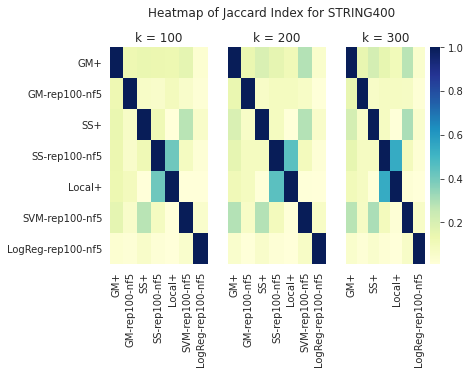

In [26]:
datasets = k_results[0].keys()
for dataset in datasets:
    f, axes = plt.subplots(ncols=3, sharey=True)
    for i, dataset_alg_prots in enumerate(k_results):
        k = k_to_test[i]
        ax = axes[i]
        alg_prots = dataset_alg_prots[dataset]
        overlap_heatmap(alg_prots, order, k, ax=ax)

    alg_str = '-'.join(algs) if len(algs) <= 3 else "%dalgs" % (len(algs))
    plt.suptitle("Heatmap of Jaccard Index for %s" % (dataset), y=1.02)
    out_file = "outputs/viz/networks/overlap/%s-%s-jaccard.pdf" % (dataset, alg_str)
    print(out_file)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    plt.savefig(out_file, bbox_inches='tight')
    plt.savefig(out_file.replace('.pdf','.png'), bbox_inches='tight')
#     plt.close()
#     break

In [11]:
def overlap_heatmap(alg_prots, order, k, ax=None, out_file=None, verbose=False):
    # compute the ovlerap between each dataset
    overlaps = defaultdict(dict)
    for i, (d1, prots1) in enumerate(sorted(alg_prots.items())):
        for j, (d2, prots2) in enumerate(sorted(alg_prots.items())):
            if j == i: 
                overlaps[d1][d2] = 1
                continue
            # intersection / union
            jaccard_index = len(set(prots1) & set(prots2)) / float(len(set(prots1) | set(prots2)))
            overlaps[d1][d2] = jaccard_index
    df = pd.DataFrame(overlaps)
    df = df[order]
    df = df.T[order].T
    if verbose:
        print(df.head())
    # now make a heatmap of all the datasets
#     f, ax = plt.subplots(figsize=(18,28))
    cbar = True if k == k_to_test[-1] else False
    ax = sns.heatmap(data=df, cmap="YlGnBu", cbar=cbar, ax=ax)
    ax.set_title("k = %s" % (k))
    if out_file is not None:
        out_file = "outputs/viz/networks/overlap/%s-%s-jaccard.pdf" % (dataset, alg_str)
        print(out_file)
        os.makedirs(os.path.dirname(out_file), exist_ok=True)
    #     plt.savefig(out_file, bbox_inches='tight')
        # plt.savefig(out_file.replace('.pdf','.png'), bbox_inches='tight')
        # also write the values to a file
    #     df.to_csv(out_file.replace('.pdf','.csv'))

In [7]:
# compute the ovlerap between each dataset
overlaps = defaultdict(dict)
for i, (d1, prots1) in enumerate(sorted(all_dataset_prots.items())):
    for j, (d2, prots2) in enumerate(sorted(all_dataset_prots.items())):
        if j == i: 
            overlaps[d1][d2] = 1
            continue
        # intersection / union
        jaccard_index = len(set(prots1) & set(prots2)) / float(len(set(prots1) | set(prots2)))
        overlaps[d1][d2] = jaccard_index
df = pd.DataFrame(overlaps)
df = df[order]
df = df.T[order].T
df.head()

,STRING400,STRING400
STRING400,1,1
STRING400,1,1


outputs/viz/networks/overlap/svm-jaccard.pdf


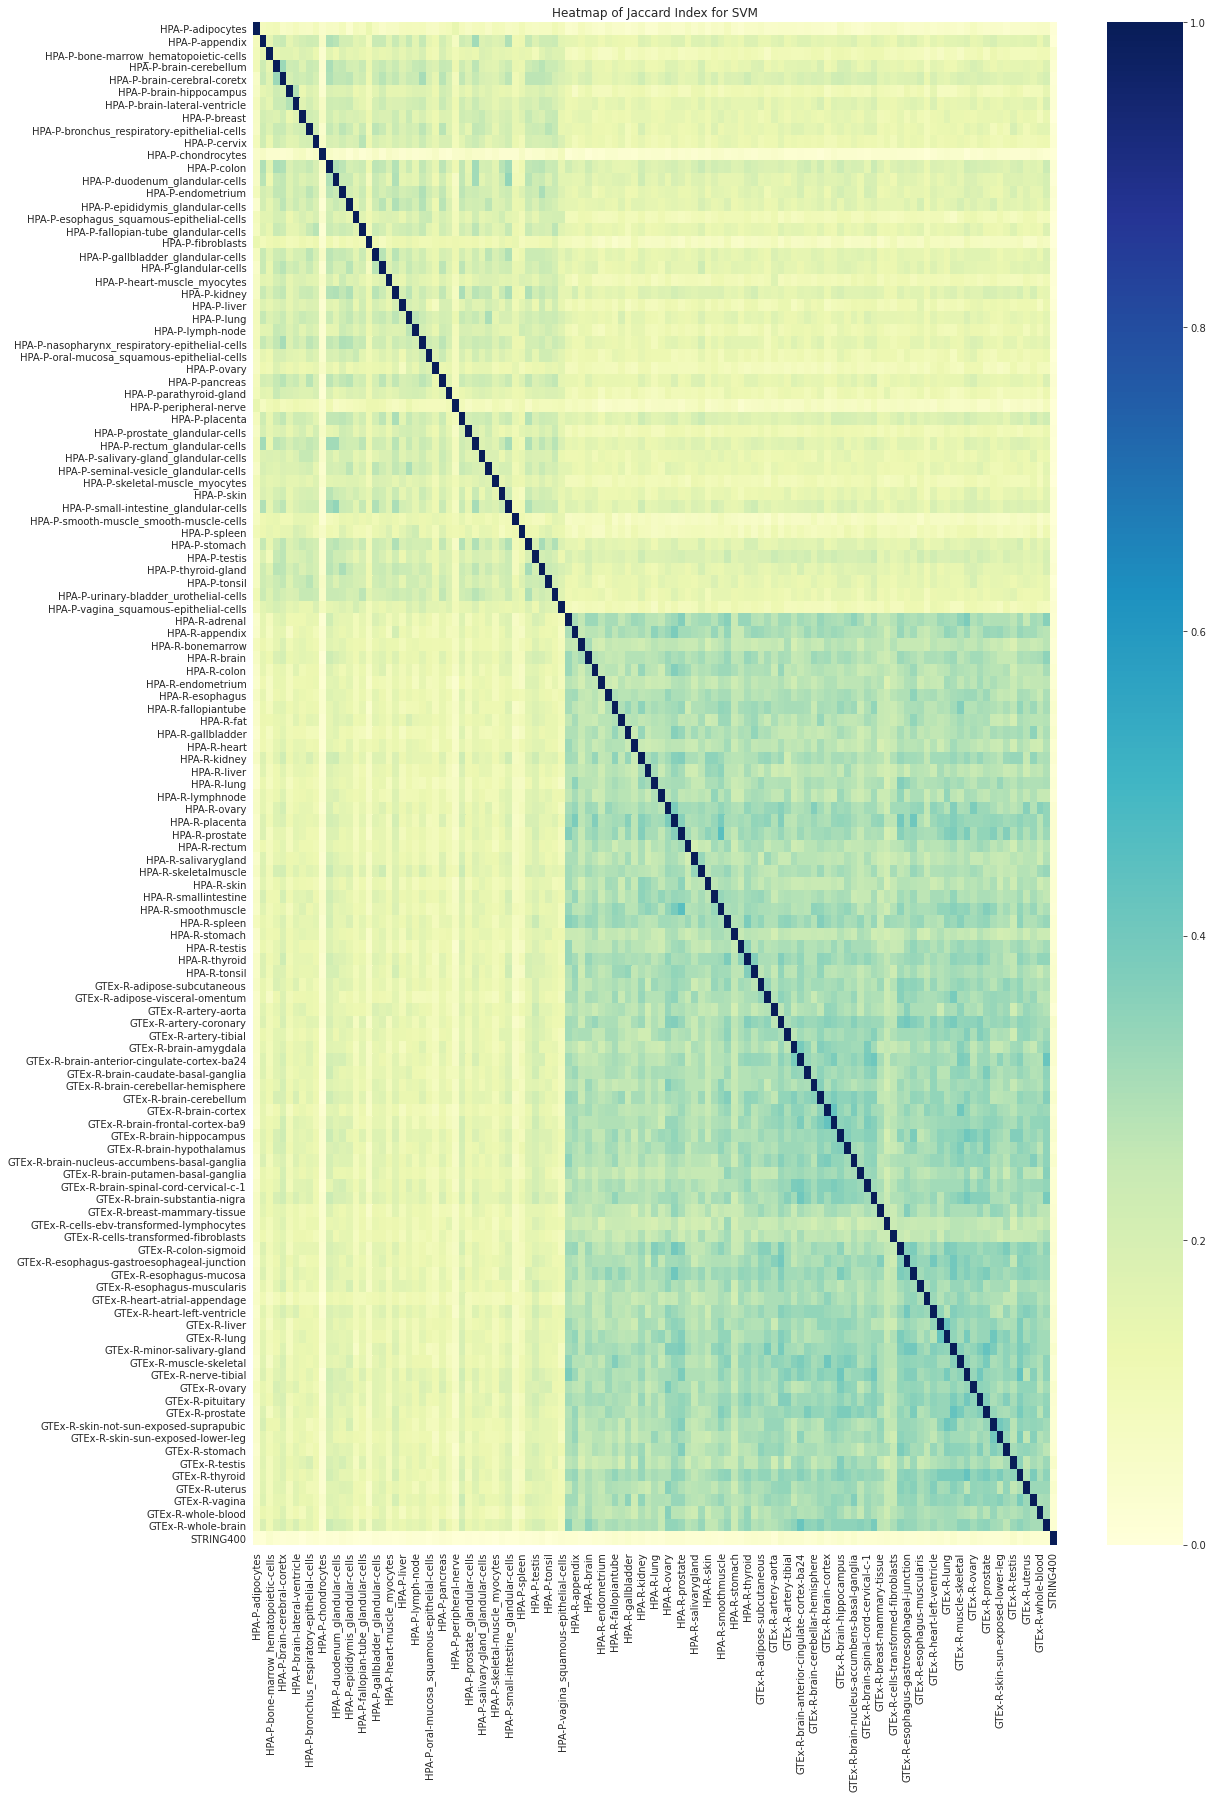

In [70]:
# now make a heatmap of all the datasets
alg = algs[0]
f, ax = plt.subplots(figsize=(18,28))
ax = sns.heatmap(data=df, cmap="YlGnBu")
ax.set_title("Heatmap of Jaccard Index for %s" % (plot_utils.ALG_NAMES.get(alg, alg)))
out_file = "outputs/viz/networks/overlap/%s-jaccard.pdf" % (alg)
print(out_file)
os.makedirs(os.path.dirname(out_file), exist_ok=True)
plt.savefig(out_file, bbox_inches='tight')
# plt.savefig(out_file.replace('.pdf','.png'), bbox_inches='tight')
# also write the values to a file
df.to_csv(out_file.replace('.pdf','.csv'))
